Connect to python API

In [1]:
%matplotlib inline

In [2]:
import twitter

# XXX: Go to http://dev.twitter.com/apps/new to create an app and get values
# for these credentials, which you'll need to provide in place of these
# empty string values that are defined as placeholders.
# See https://dev.twitter.com/docs/auth/oauth for more information 
# on Twitter's OAuth implementation.

CONSUMER_KEY = "UX8Qq4B2vuRgVOgf2TFQJKnEu"
CONSUMER_SECRET = "TyKZM2fKX85nv2t6tEXA1yXyQZZsBE9jydwImcNxxL5bQFqUvq"
OAUTH_TOKEN = "17013577-XUV1Pt3TDRlqoion44ksg7CqZrRtfxjn9tdC8GF1M"
OAUTH_TOKEN_SECRET = "Wo7rxO6R8YO77jXGsFUNRUYbnysuF9uloRKRNUynHf4eQ"

auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print twitter_api

Get US and World Trends

In [3]:
# The Yahoo! Where On Earth ID for the entire world is 1.
# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/

WORLD_WOE_ID = 1
US_WOE_ID = 23424977

# Prefix ID with the underscore for query string parameterization.
# Without the underscore, the twitter package appends the ID value
# to the URL itself as a special case keyword argument.

world_trends = twitter_api.trends.place(_id=WORLD_WOE_ID)
us_trends = twitter_api.trends.place(_id=US_WOE_ID)

In [4]:
import json

print json.dumps(world_trends, indent=1)
print
print json.dumps(us_trends, indent=1)

[
 {
  "created_at": "2016-02-02T22:43:24Z", 
  "trends": [
   {
    "url": "http://twitter.com/search?q=%23Vote1DirectionUK", 
    "query": "%23Vote1DirectionUK", 
    "tweet_volume": 816375, 
    "name": "#Vote1DirectionUK", 
    "promoted_content": null
   }, 
   {
    "url": "http://twitter.com/search?q=%23Vote5H", 
    "query": "%23Vote5H", 
    "tweet_volume": 715326, 
    "name": "#Vote5H", 
    "promoted_content": null
   }, 
   {
    "url": "http://twitter.com/search?q=%23VoteBeliebersUK", 
    "query": "%23VoteBeliebersUK", 
    "tweet_volume": 532102, 
    "name": "#VoteBeliebersUK", 
    "promoted_content": null
   }, 
   {
    "url": "http://twitter.com/search?q=%23osest%C3%BCrkiye", 
    "query": "%23osest%C3%BCrkiye", 
    "tweet_volume": 81010, 
    "name": "#osest\u00fcrkiye", 
    "promoted_content": null
   }, 
   {
    "url": "http://twitter.com/search?q=Leicester", 
    "query": "Leicester", 
    "tweet_volume": 198844, 
    "name": "Leicester", 
    "promoted_cont

In [5]:
world_trends_set = set([trend['name'] 
                        for trend in world_trends[0]['trends']])

us_trends_set = set([trend['name'] 
                     for trend in us_trends[0]['trends']]) 

common_trends = world_trends_set.intersection(us_trends_set)

print common_trends

set([u'Leicester', u'#VoteBeliebersUK', u'#VoteSelenaGomez', u'#RejectedTeamBuilding', u'Martial', u'#Vote5H', u'#Vote1DirectionUK'])


In [6]:
# Import unquote to prevent url encoding errors in next_results
from urllib import unquote

# XXX: Set this variable to a trending topic, 
# or anything else for that matter. The example query below
# was a trending topic when this content was being developed
# and is used throughout the remainder of this chapter.

#queries = list(common_trends)
queries = list(us_trends_set)


count = 100

trend_tweets = {}

# See https://dev.twitter.com/docs/api/1.1/get/search/tweets

for q in queries:

    search_results = twitter_api.search.tweets(q=q, count=count)

    statuses = search_results['statuses']


    numberOfTweets = 500
    fetchIterations = numberOfTweets/count

    for _ in range(fetchIterations):
        print "Length of statuses {} for {}".format(len(statuses), q)
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError, e: # No more results when next_results doesn't exist
            break

        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([kv.split('=') for kv in unquote(next_results[1:]).split("&") ])    


        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']

    trend_tweets[q] = statuses


Length of statuses 100 for #LCFC
Length of statuses 200 for #LCFC
Length of statuses 300 for #LCFC
Length of statuses 400 for #LCFC
Length of statuses 500 for #LCFC
Length of statuses 100 for #VoteAustinAndAlly
Length of statuses 200 for #VoteAustinAndAlly
Length of statuses 300 for #VoteAustinAndAlly
Length of statuses 400 for #VoteAustinAndAlly
Length of statuses 500 for #VoteAustinAndAlly
Length of statuses 100 for #TravelTuesday
Length of statuses 200 for #TravelTuesday
Length of statuses 300 for #TravelTuesday
Length of statuses 400 for #TravelTuesday
Length of statuses 500 for #TravelTuesday
Length of statuses 100 for Holly Rowe
Length of statuses 200 for Holly Rowe
Length of statuses 300 for Holly Rowe
Length of statuses 400 for Holly Rowe
Length of statuses 500 for Holly Rowe
Length of statuses 100 for Tony Stewart
Length of statuses 200 for Tony Stewart
Length of statuses 300 for Tony Stewart
Length of statuses 398 for Tony Stewart
Length of statuses 498 for Tony Stewart
Lengt

In [7]:
print trend_tweets.keys()
print queries
print len(queries), len(trend_tweets.keys())
print json.dumps(trend_tweets[queries[0]][0], indent=1)

[u'#LCFC', u'Jon Bunch', u'#TravelTuesday', u'Holly Rowe', u'#VoteAustinAndAlly', u'#ESSAdesign', u'#RejectedTeamBuilding', u'The Intercept', u'Rita Repulsa', u'#Vote1DirectionUK', u'#Opioids', u'Sookie', u'#SocialismChecklist', u'#IowaCaucusresults', u'Kevin Durant', u'Tornado Watch', u'Yahoo', u'Tony Stewart', u'Scooba', u'#BPLonNBC', u'#salesforcelive', u'#ewgc', u'Dele Alli', u'#ELI2016', u'#LeiLiv', u'#GrimmieSideAFeb21', u'Miles Ahead', u'#MakeMoviesMexican', u'#LetGirlsLearn', u'Lady Gaga', u'#MuppetAMovieOrSong', u'Put Emison Together In 7A', u'Forster', u'#Vote5H', u'#TWUG', u'#ThingsFoundInMyTL', u'Canelo', u'Vardy', u'Johnny Manziel', u'Leicester', u'#VoteSelenaGomez', u'#WorldWetlandsDay', u'Ride Of Your Life', u'Harry Kane', u'Martial', u'#ARMYSelcaDay', u'Dallas County', u'#VoteBeliebersUK', u'#alwx', u'#NineTrackMind']
[u'#LCFC', u'#VoteAustinAndAlly', u'#TravelTuesday', u'Holly Rowe', u'Tony Stewart', u'#ESSAdesign', u'#RejectedTeamBuilding', u'The Intercept', u'Rita Re

In [8]:
#print trend_tweets.keys()
import itertools

concatinatedText = {}

for trend in trend_tweets.keys():
    tweet_list = trend_tweets[trend]
    #print tweet_list[0]
    concatinatedText[trend] = ''.join([ status['text']
                                for status in tweet_list])

print len(trend_tweets.keys())

50


In [28]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, stop_words = 'english',\
strip_accents = 'unicode', lowercase=True, ngram_range=(1,2),\
norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)
X = vectorizer.fit_transform(concatinatedText.values())
D = -(X * X.T).todense()
#print D
print len(D)



50


In [30]:
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'lequipedusoir edsrt', u'mientras', u'diva', u'minha mae', u'minhas', u'disso', u'disse', u'minute visit', u'dismiss', u'dishwasher rt', u'mio', u'miracle', u'dishwasher', u'mirondo', u'disease', u'mirror page', u'discussion', u'mirrorfootball leicester', u'discusses', u'misery']


In [10]:
import numpy as np
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
coords = model.fit_transform(D) 
print coords


[[  62.84503982  196.54328627]
 [-132.82496504   -1.47482559]
 [   8.85245658  126.17219063]
 [  28.39388647 -133.56424125]
 [ -16.59260197  -65.45571101]
 [-126.78416726   51.13381446]
 [ -86.51002022  -25.13734068]
 [  67.27422994   22.6928031 ]
 [ -98.379215     17.32975718]
 [  93.25334722   52.13351549]
 [  -8.47388149 -115.57629138]
 [ 137.91107977  159.30744996]
 [ 122.7710562    78.42581324]
 [ -21.87743929  -30.20842879]
 [   7.63653191 -168.34228048]
 [ 411.63666677   64.56868904]
 [  52.30622502  -84.57307756]
 [  72.5632856  -121.06905284]
 [-431.80966725  -34.21109715]
 [ -55.29808907  -53.48572411]
 [  51.78716075  110.35428234]
 [ -33.76375935   69.14209115]
 [  18.72688619  -86.43014273]
 [ -24.44235656  104.07309707]
 [ 148.78414129 -240.13677783]
 [  99.87414558  -70.5457646 ]
 [ -56.38648212   -3.99306053]
 [ -77.74957086   79.07760102]
 [  17.87640218   85.88253348]
 [ -82.8713048  -116.53539377]
 [-122.15455377  100.42613676]
 [  15.26016703  -39.46493836]
 [ -26.8

In [11]:
#import matplotlib.pyplot as plt

vis_x = coords[:, 0]
vis_y = coords[:, 1]

print coords
print vis_x

#plt.scatter(vis_x, vis_y)
#plt.show()

[[  62.84503982  196.54328627]
 [-132.82496504   -1.47482559]
 [   8.85245658  126.17219063]
 [  28.39388647 -133.56424125]
 [ -16.59260197  -65.45571101]
 [-126.78416726   51.13381446]
 [ -86.51002022  -25.13734068]
 [  67.27422994   22.6928031 ]
 [ -98.379215     17.32975718]
 [  93.25334722   52.13351549]
 [  -8.47388149 -115.57629138]
 [ 137.91107977  159.30744996]
 [ 122.7710562    78.42581324]
 [ -21.87743929  -30.20842879]
 [   7.63653191 -168.34228048]
 [ 411.63666677   64.56868904]
 [  52.30622502  -84.57307756]
 [  72.5632856  -121.06905284]
 [-431.80966725  -34.21109715]
 [ -55.29808907  -53.48572411]
 [  51.78716075  110.35428234]
 [ -33.76375935   69.14209115]
 [  18.72688619  -86.43014273]
 [ -24.44235656  104.07309707]
 [ 148.78414129 -240.13677783]
 [  99.87414558  -70.5457646 ]
 [ -56.38648212   -3.99306053]
 [ -77.74957086   79.07760102]
 [  17.87640218   85.88253348]
 [ -82.8713048  -116.53539377]
 [-122.15455377  100.42613676]
 [  15.26016703  -39.46493836]
 [ -26.8

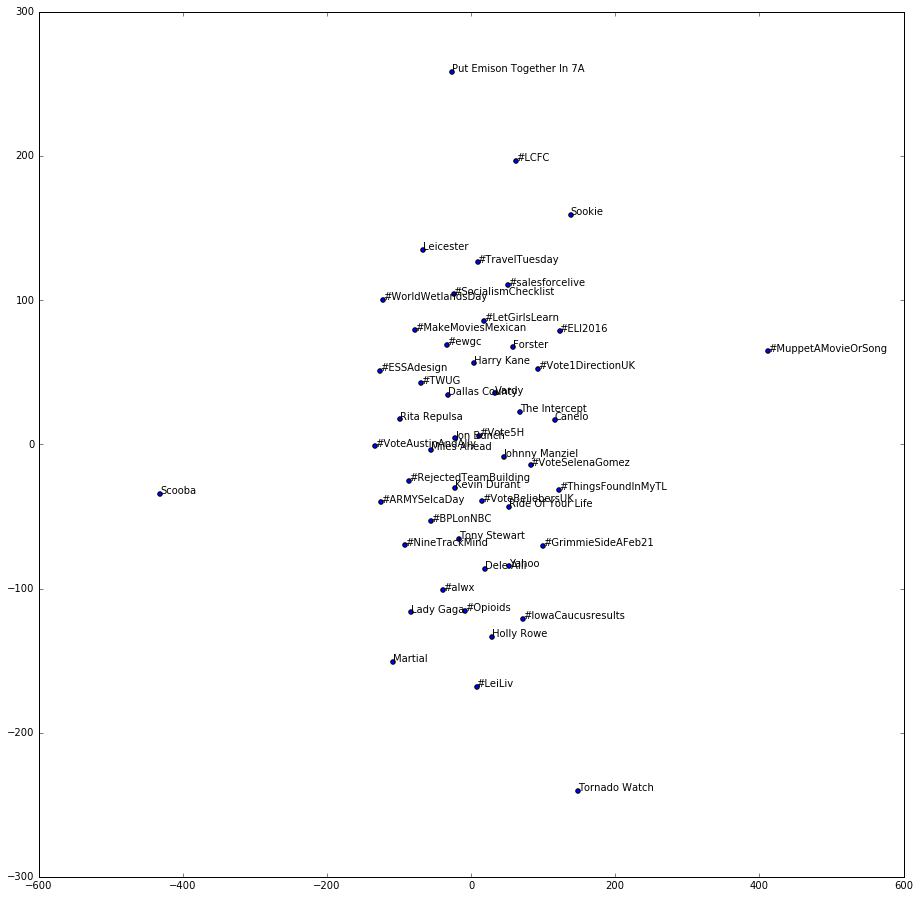

In [24]:
import matplotlib.pyplot as plt

plt.scatter(vis_x, vis_y)

for i, txt in enumerate(queries):
    plt.annotate(txt, (vis_x[i],vis_y[i]))

fig = plt.gcf()
fig.set_size_inches(15.5, 15.5)

plt.show()

